### Linear KF on Non-linear Data

This example demonstrates a fundamental conflict between the true nature of the system and the model given to the linear Kalman filter.

***

#### 1. The True Nonlinear System Model

The state of the vehicle at time $k$ is given by the vector:
$$x_k = \begin{bmatrix} p_{x,k} \\ p_{y,k} \\ v_{x,k} \\ v_{y,k} \end{bmatrix}$$

The true evolution of the system is described by a **nonlinear function** $f(\cdot)$, such that $x_k = f(x_{k-1}) + w_{k-1}$. The function $f(x_{k-1})$ is defined by the following set of equations, where $\omega$ is the turn rate:

* $v_{x,k} = v_{x,k-1} \cos(\omega \Delta t) - v_{y,k-1} \sin(\omega \Delta t)$
* $v_{y,k} = v_{x,k-1} \sin(\omega \Delta t) + v_{y,k-1} \cos(\omega \Delta t)$
* $p_{x,k} = p_{x,k-1} + v_{x,k} \Delta t$
* $p_{y,k} = p_{y,k-1} + v_{y,k} \Delta t$

The `sin` and `cos` terms make this transformation nonlinear. There is no single matrix $F$ that can represent this rotation for all velocities.

The measurement model, however, is linear. The sensor measures position:
$$y_k = H x_k + v_k \quad \text{where} \quad H = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \end{bmatrix}$$

***

#### 2. The Incorrect Linear Model Given to the Filter

The standard Kalman filter *requires* a linear model of the form $x_k = F x_{k-1} + w_{k-1}$. To use it, we are forced to supply a linear state transition matrix `F`. In the code, we use the standard **Constant Velocity model**:

$$F_{linear} = \begin{bmatrix} 1 & 0 & \Delta t & 0 \\ 0 & 1 & 0 & \Delta t \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}$$

This matrix is built on the assumption that velocity is constant:
* $v_{x,k} = v_{x,k-1}$
* $v_{y,k} = v_{y,k-1}$

This is a valid model for an object moving in a straight line, but it is fundamentally incorrect for a turning object.

***

#### 3. The Source of the Failure

The failure occurs in the filter's **prediction step**:

$$\hat{x}_k^- = F_{linear} \hat{x}_{k-1}^+$$

1.  **The Prediction:** The filter uses $F_{linear}$ to predict the next state. Because this matrix assumes constant velocity, the predicted path will always be a straight line tangential to the last known trajectory.

2.  **The Reality:** The true system turns, causing its actual state $x_k$ to diverge significantly from the straight-line prediction $\hat{x}_k^-$.

3.  **The Conflict:** The filter receives a new measurement $y_k$ from the actual curved path. It calculates the difference between this measurement and its prediction (the innovation): $y_k - H \hat{x}_k^-$. During the turn, this innovation becomes very large, not because of random noise, but because of the systematic **model error**.

The Kalman filter's core assumption is that the prediction error is dominated by small, random process noise $w_k$. When the error is actually large, systematic, and caused by a flawed model, the filter's mathematical foundation breaks down. It cannot reconcile its internal belief (straight-line motion) with the reality presented by the measurements (curved motion), leading to the catastrophic divergence seen in the plot.

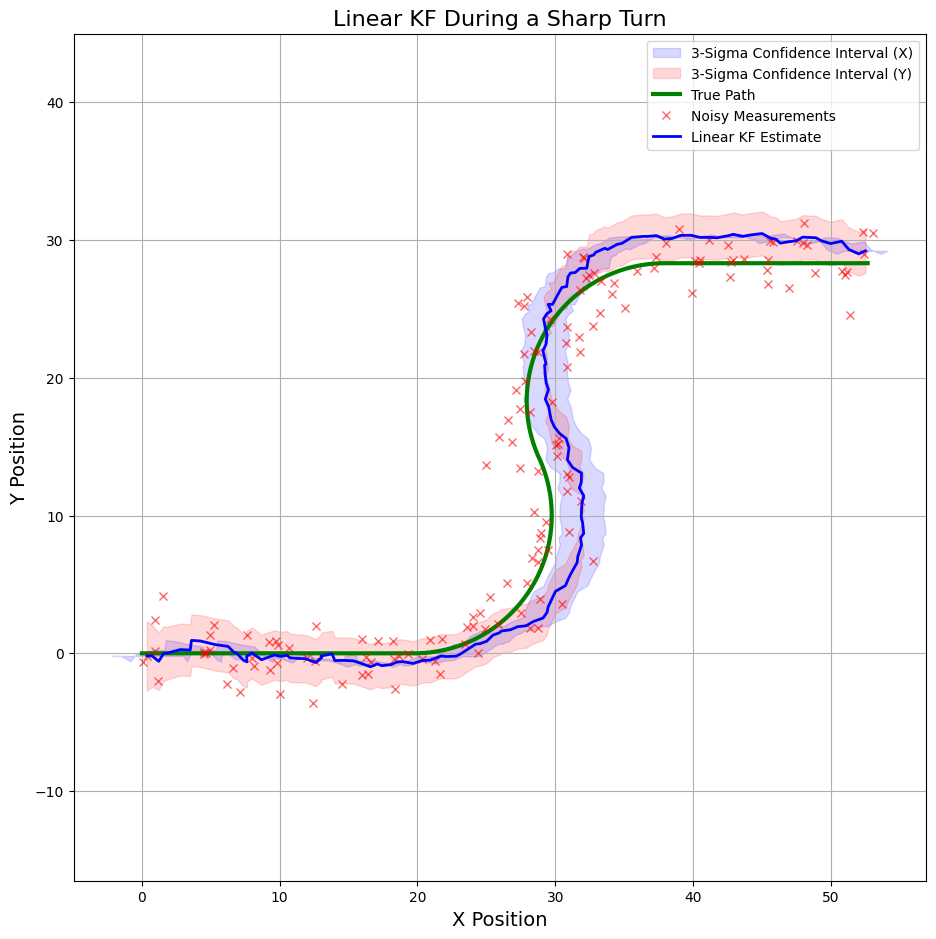

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def kalman_filter(y, F, H, Q, R, x0, P0):
    """The same linear Kalman filter function."""
    num_steps = y.shape[0]
    num_states = F.shape[0]
    num_measurements = H.shape[0]
    x_hat = x0
    P = P0
    I = np.eye(num_states)
    innovation_means = np.zeros((num_steps, num_measurements, 1))
    innovation_covariances = np.zeros((num_steps, num_measurements, num_measurements))

    x_estimates = np.zeros((num_steps, num_states, 1))
    P_history = np.zeros((num_steps, num_states, num_states))
    x_estimates[0] = x_hat
    P_history[0] = P

    for k in range(num_steps):
        # Predict
        x_hat_minus = F @ x_hat
        P_minus = F @ P @ F.T + Q
        # Update
        K = P_minus @ H.T @ np.linalg.inv(H @ P_minus @ H.T + R)
        innovation = y[k] - H @ x_hat_minus
        x_hat = x_hat_minus + K @ (innovation)
        P = (I - K @ H) @ P_minus

        x_estimates[k] = x_hat
        P_history[k] = P
        innovation_means[k] = innovation
        innovation_covariances[k] = H @ P_minus @ H.T + R

    return x_estimates, P_history, innovation_means, innovation_covariances

# --- 1. Setup the Nonlinear Simulation with a Sharp Turn ---
dt = 0.1
num_steps = 150
v = 5.0 # Constant speed

# --- 2. Generate the True Nonlinear Trajectory ---
# State is now [px, py, vx, vy]
true_states = np.zeros((num_steps, 4, 1))
true_states[0] = np.array([[0], [0], [v], [0]]) # Initial state: at origin, moving along x-axis

for k in range(1, num_steps):
    px_prev, py_prev, vx_prev, vy_prev = true_states[k-1].flatten()

    # After 5 seconds, start a sharp turn (0.4 rad/s)
    if k * dt > 12: omega = 0.0
    elif k * dt > 8: omega = -0.5
    elif k * dt > 4: omega = 0.5
    else: omega = 0.0

    # Rotate velocity vector
    vx_k = vx_prev * np.cos(omega * dt) - vy_prev * np.sin(omega * dt)
    vy_k = vx_prev * np.sin(omega * dt) + vy_prev * np.cos(omega * dt)

    # Update position
    px_k = px_prev + vx_k * dt
    py_k = py_prev + vy_k * dt

    true_states[k] = np.array([[px_k], [py_k], [vx_k], [vy_k]])

# --- 3. Generate Noisy Measurements ---
# Sensor measures only position (px, py)
H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])
r_std = 1.5
R = np.eye(2) * r_std**2
measurements = np.zeros((num_steps, 2, 1))
for k in range(num_steps):
    noise = np.random.multivariate_normal([0, 0], R)
    measurements[k] = H @ true_states[k] + noise.reshape(2, 1)

# --- 4. Run the Linear KF with the Constant Velocity Model ---
# This F matrix assumes vx and vy are constant, which is WRONG for a turn.
F_linear = np.array([[1, 0, dt, 0],
                     [0, 1, 0, dt],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])

# Process noise: We add some uncertainty to the model
q_val = 0.01
Q = np.eye(4) * q_val

# Initial guesses
x0_guess = np.array([[0], [0], [v], [0]])
P0_guess = np.eye(4) * 1.0

# Run the filter
filtered_states, filtered_P, innovation_means, innovation_covariances = kalman_filter(measurements, F_linear, H, Q, R, x0_guess, P0_guess)

# --- 5. Plot the Results ---
time = np.arange(0, num_steps * dt, dt)

# Extract the position uncertainty (standard deviation)
px_std = np.sqrt(filtered_P [:, 0, 0])
py_std = np.sqrt(filtered_P [:, 1, 1])

# Get the 3-sigma bounds for x and y
lower_bound_x = filtered_states [:, 0, 0] - 3 * px_std
upper_bound_x = filtered_states [:, 0, 0] + 3 * px_std
lower_bound_y = filtered_states [:, 1, 0] - 3 * py_std
upper_bound_y = filtered_states [:, 1, 0] + 3 * py_std

plt.figure(figsize=(11, 11))

# Plot the 3-sigma confidence interval for x and y
plt.fill_betweenx(filtered_states [:, 1, 0], lower_bound_x, upper_bound_x, color='b', alpha=0.15, label='3-Sigma Confidence Interval (X)')
plt.fill_between(filtered_states [:, 0, 0], lower_bound_y, upper_bound_y, color='r', alpha=0.15, label='3-Sigma Confidence Interval (Y)')

plt.plot(true_states[:, 0], true_states[:, 1], 'g-', linewidth=3, label='True Path')
plt.plot(measurements[:, 0], measurements[:, 1], 'rx', markersize=6, alpha=0.6, label='Noisy Measurements')
plt.plot(filtered_states[:, 0], filtered_states[:, 1], 'b-', linewidth=2, label='Linear KF Estimate')

plt.title('Linear KF During a Sharp Turn', fontsize=16)
plt.xlabel('X Position', fontsize=14)
plt.ylabel('Y Position', fontsize=14)
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

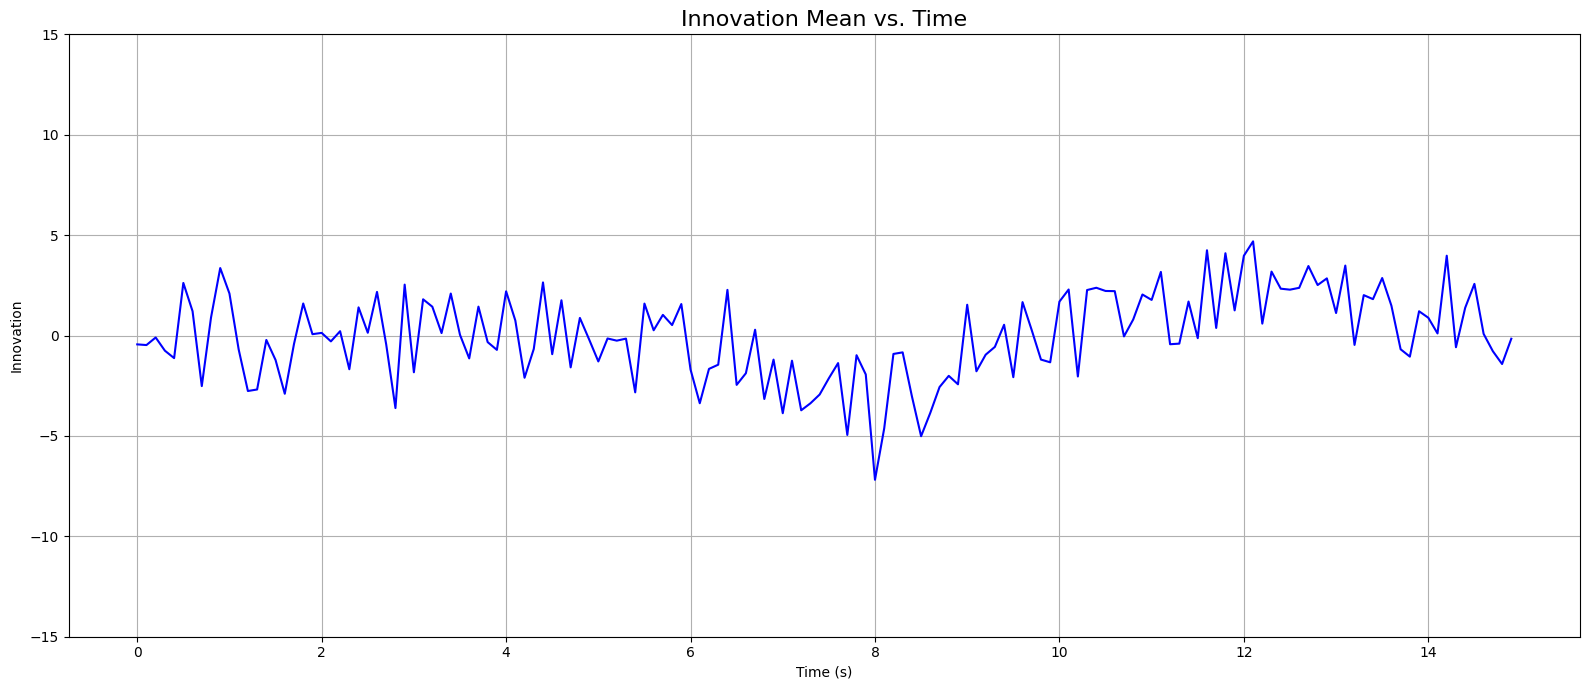

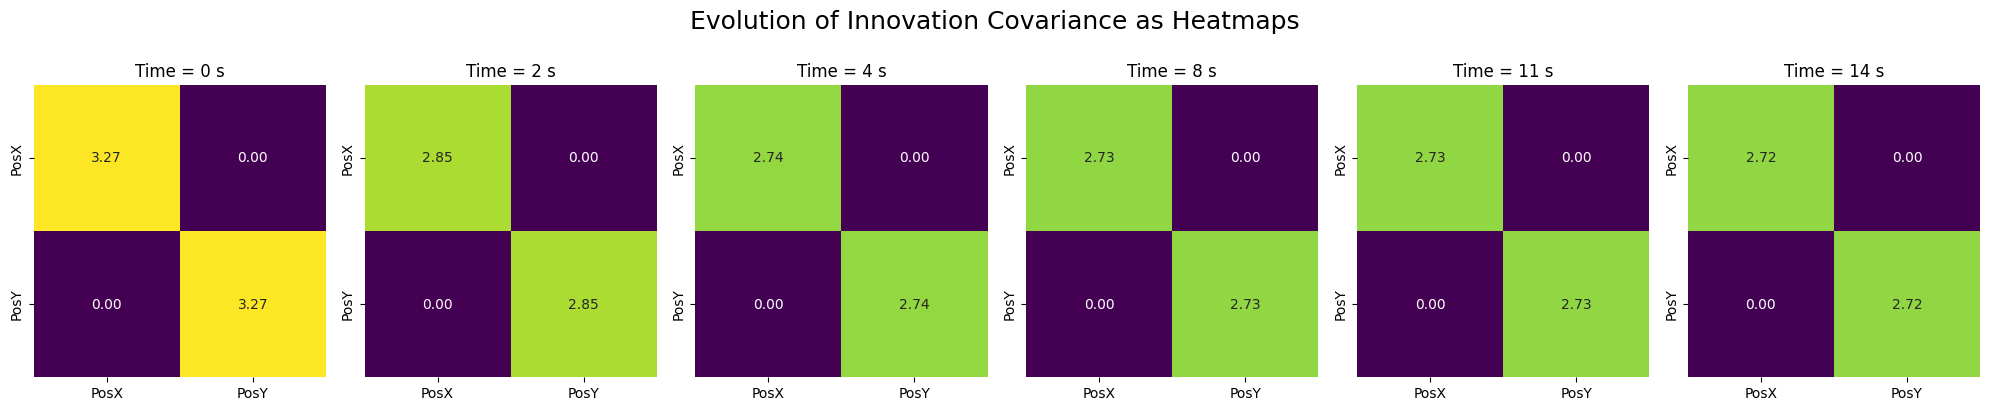

In [ ]:
import matplotlib.animation as animation
import seaborn as sns

# --- 4. Plot the Innovation ---
fig, (ax1) = plt.subplots(1, 1, figsize=(16, 7))

# Plot 1: Innovation Mean (Static)
ax1.plot(time, innovation_means[:, 0, 0], 'b-')
ax1.set_title('Innovation Mean vs. Time', fontsize=16)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Innovation')
ax1.grid(True)
ax1.set_ylim(-15, 15) # Set fixed y-axis for better visualization

plt.tight_layout()
plt.show()

# --- 4. Plot Innovation Covariance at Different Timesteps ---
# Timesteps to plot (every 20 seconds, since dt=1.0)
plot_steps = [0, 2, 4, 8, 11, 14]
num_plots = len(plot_steps)
fig, axes = plt.subplots(1, num_plots, figsize=(20, 4))
fig.suptitle('Evolution of Innovation Covariance as Heatmaps', fontsize=18)

# Find a global min/max for consistent color scaling across all heatmaps
vmin = np.min(innovation_covariances)
vmax = np.max(innovation_covariances[0]) # Use max from the first step for scale

for i, step in enumerate(plot_steps):
    ax = axes[i]
    sns.heatmap(innovation_covariances[step], ax=ax, annot=True, fmt=".2f",
                cmap="viridis", cbar=False, vmin=vmin, vmax=vmax,
                xticklabels=['PosX', 'PosY'], yticklabels=['PosX', 'PosY'])
    ax.set_title(f'Time = {step} s')
    ax.set_aspect('equal') # Make heatmap cells square

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()